## 📋 Requirements & Test Case Tracking Rules

### 1. **ID System**
- All requirements and test cases use a unified, hierarchical, zero-padded ID system:
  - **Epics:** `00`
  - **Features:** `00.00`
  - **User Stories:** `00.00.00`
  - **Test Cases:** `00.00.TC00` (Feature-based, e.g., `01.02.TC01`)
- All relationships are encoded in these IDs; no legacy columns.

### 2. **CSV Formatting**
- All requirements and test case CSVs use semicolon (`;`) as delimiter.
- All fields with commas are quoted.
- All rows match the header structure; no extra or missing columns.

### 3. **Column Naming**
- All requirement/user story/feature/epic name columns are called `REQTitle`.
- All test case name columns are called `TCTitle`.

### 4. **Whitespace Handling**
- All string fields are stripped of leading/trailing whitespace before processing or comparison.

### 5. **Health Check Rules**
- All IDs must be unique and non-empty.
- All assignments (e.g., test case to user story) must reference valid, existing IDs.
- No empty required fields.
- **Each Feature must have at least two User Stories assigned** to pass the health check.
- **Each User Story must have at least two Test Cases assigned** (n:m assignment allowed) to pass the health check.
- **Test Case IDs must follow the pattern:** `00.00.TC00` (Feature-based, e.g., `01.02.TC01`).

---

### What the Code Cells Do

- **Cell 1: Health Check & Data Merge**
  - Loads and cleans `use_cases.csv` and `test_cases.csv`.
  - Checks for missing/duplicate IDs, empty fields, invalid assignments, and enforces the above rules.
  - Prints a health report with any issues found.
  - Updates `use_cases_and_test_cases.csv` with the merged associations for traceability.

- **Cell 2: Coverage & Completion Calculation**
  - Calculates and displays coverage and completion for user stories, features, and epics.
  - Coverage for user stories: 1 test case = 50%, 2+ = 100%.
  - Coverage for features/epics: average of their children.
  - Completion: % of test cases passed (user story), average for features/epics.
  - Shows tables and bar charts for coverage and completion, with color gradients from red (0%) to yellow (50%) to green (100%).
  - Prints overall percentages for each level.

## 📋 Requirements & Test Case Tracking Rules

### 1. **ID System**
- All requirements and test cases use a unified, hierarchical, zero-padded ID system:
  - **Epics:** `00`
  - **Features:** `00.00`
  - **User Stories:** `00.00.00`
  - **Test Cases:** `00.00.TC00` (Feature-based, e.g., `01.02.TC01`)
- All relationships are encoded in these IDs; no legacy columns.

### 2. **CSV Formatting**
- All requirements and test case CSVs use semicolon (`;`) as delimiter.
- All fields with commas are quoted.
- All rows match the header structure; no extra or missing columns.

### 3. **Column Naming**
- All requirement/user story/feature/epic name columns are called `REQTitle`.
- All test case name columns are called `TCTitle`.

### 4. **Whitespace Handling**
- All string fields are stripped of leading/trailing whitespace before processing or comparison.

### 5. **Health Check Rules**
- All IDs must be unique and non-empty.
- All assignments (e.g., test case to user story) must reference valid, existing IDs.
- No empty required fields.
- **Each Feature must have at least two User Stories assigned** to pass the health check.
- **Each User Story must have at least two Test Cases assigned** (n:m assignment allowed) to pass the health check.
- **Test Case IDs must follow the pattern:** `00.00.TC00` (Feature-based, e.g., `01.02.TC01`).

---

### What the Code Cells Do

- **Cell 1: Health Check & Data Merge**
  - Loads and cleans `use_cases.csv` and `test_cases.csv`.
  - Checks for missing/duplicate IDs, empty fields, invalid assignments, and enforces the above rules.
  - Prints a health report with any issues found.
  - Updates `use_cases_and_test_cases.csv` with the merged associations for traceability.

- **Cell 2: Coverage & Completion Calculation**
  - Calculates and displays coverage and completion for user stories, features, and epics.
  - Coverage for user stories: 1 test case = 50%, 2+ = 100%.
  - Coverage for features/epics: average of their children.
  - Completion: % of test cases passed (user story), average for features/epics.
  - Shows tables and bar charts for coverage and completion, with color gradients from red (0%) to yellow (50%) to green (100%).
  - Prints overall percentages for each level.

In [1]:
import pandas as pd

# Load dataframes from the 'requirements/' directory
uc_df = pd.read_csv('use_cases.csv', sep=';')
tc_df = pd.read_csv('test_cases.csv', sep=';')
reqid_tcid_df = pd.read_csv('REQID_TCID.csv', sep=';')

rows = []
for index, row in uc_df.iterrows():
    if row['REQType'] == 'UserStory':
        # Find all TCIDs associated with this User Story REQID from the mapping file
        associated_tcids = reqid_tcid_df[reqid_tcid_df['REQID'] == row['REQID']]['TCID'].tolist()

        if associated_tcids:
            for tcid in associated_tcids:
                # Find the test case details in tc_df using the TCID
                matching_tc = tc_df[tc_df['TCID'] == tcid]
                if not matching_tc.empty:
                    tc_row = matching_tc.iloc[0] # Get the first (and hopefully only) match
                    merged = row.copy()
                    merged['TCID'] = tc_row['TCID']
                    merged['TCTitle'] = tc_row['TCTitle']
                    merged['AssignmentType'] = 'Covers' # As specified in the original combined CSV
                    merged['Status'] = tc_row['Status']
                    merged['UserNotes'] = '' # Assuming UserNotes is for the main Use Case, not per TC
                    rows.append(merged)
                else:
                    # Case where TCID is in REQID_TCID.csv but not found in test_cases.csv
                    merged = row.copy()
                    merged['TCID'] = tcid
                    merged['TCTitle'] = f"Test Case {tcid} (Details Missing)"
                    merged['AssignmentType'] = 'Covers'
                    merged['Status'] = 'missing' # Mark as missing if test case details are absent
                    merged['UserNotes'] = 'Test case details not found in test_cases.csv'
                    rows.append(merged)
        else:
            # If a User Story has no associated test cases in REQID_TCID.csv
            merged = row.copy()
            merged['TCID'] = ''
            merged['TCTitle'] = ''
            merged['AssignmentType'] = ''
            merged['Status'] = 'untested' # Mark User Story as untested if no TCs
            merged['UserNotes'] = ''
            rows.append(merged)
    else:
        # For Epics and Features, they do not have direct test cases; they are covered by their children's tests
        merged = row.copy()
        merged['TCID'] = ''
        merged['TCTitle'] = ''
        merged['AssignmentType'] = ''
        merged['Status'] = ''
        merged['UserNotes'] = ''
        rows.append(merged)

columns = ['REQID', 'REQType', 'REQTitle', 'TCID', 'TCTitle', 'AssignmentType', 'Status', 'UserNotes']
merged_df = pd.DataFrame(rows)[columns]
merged_df.to_csv('use_cases_and_test_cases.csv', sep=';', index=False)
print("Updated use_cases_and_test_cases.csv with merged associations.")

Updated use_cases_and_test_cases.csv with merged associations.


In [2]:
# import pandas as pd

# # Load CSVs with semicolon delimiter
# uc = pd.read_csv('use_cases.csv', delimiter=';', dtype=str).fillna('')
# tc = pd.read_csv('test_cases.csv', delimiter=';', dtype=str).fillna('')

# # Strip whitespace from all string columns
# uc = uc.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# tc = tc.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# issues = []

# # Required columns
# required_uc = {'REQID', 'REQType', 'REQTitle'}
# required_tc = {'TCID', 'TCTitle', 'REQID'}

# if not required_uc.issubset(uc.columns):
#     issues.append(f"Missing columns in use_cases.csv: {required_uc - set(uc.columns)}")
# if not required_tc.issubset(tc.columns):
#     issues.append(f"Missing columns in test_cases.csv: {required_tc - set(tc.columns)}")

# # Check for empty or duplicate IDs
# if uc['REQID'].isnull().any() or (uc['REQID'] == '').any():
#     issues.append('Empty REQID in use_cases.csv')
# if tc['TCID'].isnull().any() or (tc['TCID'] == '').any():
#     issues.append('Empty TCID in test_cases.csv')
# if uc['REQID'].duplicated().any():
#     issues.append('Duplicate REQID in use_cases.csv')
# if tc['TCID'].duplicated().any():
#     issues.append('Duplicate TCID in test_cases.csv')

# # Check for empty required fields
# for col in required_uc:
#     if uc[col].isnull().any() or (uc[col] == '').any():
#         issues.append(f"Empty required field {col} in use_cases.csv")
# for col in required_tc:
#     if tc[col].isnull().any() or (tc[col] == '').any():
#         issues.append(f"Empty required field {col} in test_cases.csv")

# # Check for invalid assignments (test cases referencing non-existent user stories)
# user_story_ids = set(uc[uc['REQType'] == 'UserStory']['REQID'])
# invalid_tc = tc[~tc['REQID'].isin(user_story_ids)]
# if not invalid_tc.empty:
#     issues.append(f"Test cases assigned to non-existent User Story REQID: {invalid_tc[['TCID','REQID']].values.tolist()}")

# # Each Feature must have at least 2 user stories
# features = uc[uc['REQType'] == 'Feature']
# user_stories = uc[uc['REQType'] == 'UserStory']
# feature_to_us = user_stories.copy()
# feature_to_us['FeatureID'] = feature_to_us['REQID'].str.slice(0, 5)
# feature_us_counts = feature_to_us.groupby('FeatureID').size()
# features_with_few_us = feature_us_counts[feature_us_counts < 2].index.tolist()
# if features_with_few_us:
#     issues.append("Features with fewer than 2 user stories: " + str(features_with_few_us))

# # Each User Story must have at least 2 test cases assigned (n:m allowed)
# us_tc_counts = tc.groupby('REQID').size()
# us_with_few_tc = us_tc_counts[us_tc_counts < 2].index.tolist()
# if us_with_few_tc:
#     issues.append("User stories with fewer than 2 test cases: " + str(us_with_few_tc))

# # Print health report
# if not issues:
#     print("✅ Health check passed: All requirements and test cases are consistent and meet all rules.")
# else:
#     print("❌ Health check failed. Issues found:")
#     for issue in issues:
#         print("-", issue)

# # --- Update use_cases_and_test_cases.csv ---
# rows = []
# for _, req_row in uc.iterrows():
#     reqid = req_row['REQID']
#     reqtype = req_row['REQType']
#     row = req_row.to_dict()
#     if reqtype == 'UserStory':
#         assigned_tcs = tc[tc['REQID'] == reqid]
#         if not assigned_tcs.empty:
#             for _, tc_row in assigned_tcs.iterrows():
#                 merged = row.copy()
#                 merged['TCID'] = tc_row['TCID']
#                 merged['TCTitle'] = tc_row['TCTitle']
#                 merged['AssignmentType'] = 'Covers'
#                 merged['Status'] = tc_row.get('status', '')
#                 merged['UserNotes'] = tc_row.get('notes', '')
#                 rows.append(merged)
#         else:
#             merged = row.copy()
#             merged['TCID'] = ''
#             merged['TCTitle'] = ''
#             merged['AssignmentType'] = ''
#             merged['Status'] = ''
#             merged['Notes'] = ''
#             rows.append(merged)
#     else:
#         merged = row.copy()
#         merged['TCID'] = ''
#         merged['TCTitle'] = ''
#         merged['AssignmentType'] = ''
#         merged['Status'] = ''
#         merged['Notes'] = ''
#         rows.append(merged)

# columns = ['REQID', 'REQType', 'REQTitle', 'TCID', 'TCTitle', 'AssignmentType', 'Status', 'UserNotes']
# merged_df = pd.DataFrame(rows)[columns]
# merged_df.to_csv('use_cases_and_test_cases.csv', sep=';', index=False)
# print("Updated use_cases_and_test_cases.csv with merged associations.")

,REQID,REQType,REQTitle,child_count,TC_count,Coverage,Completion
0,01.01.01,UserStory,"As a developer, I want to create core timefram...",0,7,100.0%,100.0%
1,01.01.01,UserStory,"As a developer, I want to create core timefram...",0,7,100.0%,100.0%
2,01.01.01,UserStory,"As a developer, I want to create core timefram...",0,7,100.0%,100.0%
3,01.01.01,UserStory,"As a developer, I want to create core timefram...",0,7,100.0%,100.0%
4,01.01.01,UserStory,"As a developer, I want to create core timefram...",0,7,100.0%,100.0%
...,...,...,...,...,...,...,...
108,03,Epic,Market Whisperer Integration Layer,7,11,50.0%,42.9%
109,04,Epic,Frontend Components Adaptation,4,5,50.0%,0.0%
110,05,Epic,Configuration and Factory Updates,4,4,50.0%,0.0%
111,06,Epic,Testing and Validation,6,6,50.0%,0.0%


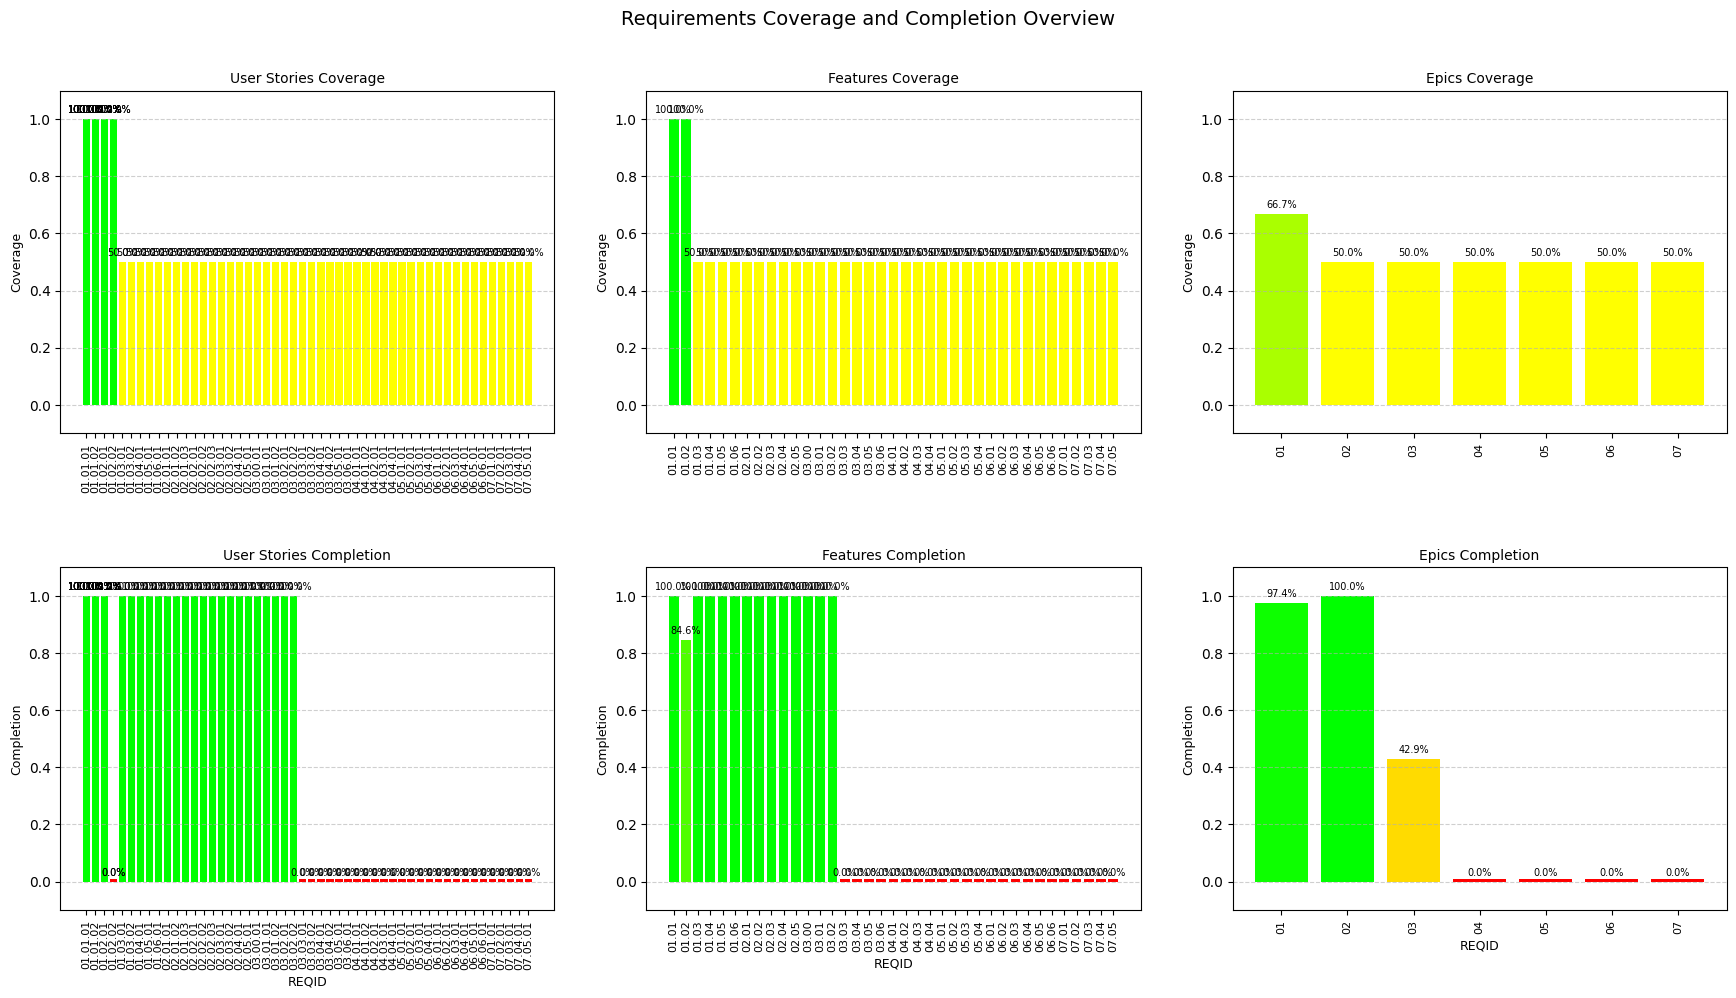

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load and clean data ---
# uc is loaded from 'use_cases_and_test_cases.csv' which is generated by the first cell.
# This CSV merges use case information with linked test case details, including status.
uc = pd.read_csv('use_cases_and_test_cases.csv', sep=';')
# Strip whitespace from all string columns to ensure clean data for comparisons
uc = uc.apply(lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x))

# --- Identify types ---
# Separate DataFrames for epics, features, and user stories are created from the main 'uc' DataFrame.
epics = uc[uc['REQType'] == 'Epic'].copy()
features = uc[uc['REQType'] == 'Feature'].copy()
user_stories = uc[uc['REQType'] == 'UserStory'].copy()

# --- User Story <-> Test Case mapping (n:m) ---
# 'us_tc_links' creates a mapping of User Story REQIDs to their linked TCIDs.
# It filters out rows where TCID might be NaN (though 'dropna' should handle this).
us_tc_links = user_stories[['REQID', 'TCID']].dropna(subset=['TCID'])

# CORRECTED DEFINITION FOR 'tc_status':
# 'tc_status' should be a lookup table from TCID to its Status.
# This information is extracted from the 'uc' DataFrame by selecting rows that have a valid TCID,
# then keeping only the 'TCID' and 'Status' columns, and dropping duplicates to ensure unique TCID entries.
tc_status = uc[uc['TCID'].notna() & (uc['TCID'] != '')][['TCID', 'Status']].drop_duplicates()

# --- User Story Coverage & Completion ---
# Count actual test cases linked per user story
us_tc_counts = us_tc_links.groupby('REQID').size()
user_stories['TC_count'] = user_stories['REQID'].map(us_tc_counts).fillna(0).astype(int)

# Coverage: 0 for 0 TCs, 0.5 for 1 TC, 1.0 for 2+ TCs.
def us_coverage(n):
    if n == 0:
        return 0.0
    elif n == 1:
        return 0.5
    else:
        return 1.0
user_stories['Coverage'] = user_stories['TC_count'].apply(us_coverage)

# Completion: % of linked test cases passed for a user story
def us_completion(reqid):
    linked_tcs_for_reqid = us_tc_links[us_tc_links['REQID'] == reqid]
    if linked_tcs_for_reqid.empty:
        return 0.0
    merged_status = linked_tcs_for_reqid.merge(tc_status, on='TCID', how='left')
    merged_status['Status'] = merged_status['Status'].fillna('').astype(str)
    # print(f"DEBUG: Unique statuses for REQID {reqid}: {merged_status['Status'].unique()}") # Debug line
    passed_tcs = merged_status[merged_status['Status'].str.strip().str.lower() == 'passed'].shape[0]
    total_tcs = merged_status.shape[0]
    # print(f"DEBUG: Passed TCs for REQID {reqid}: {passed_tcs}, Total TCs: {total_tcs}") # Debug line
    if total_tcs == 0:
        return 0.0
    return passed_tcs / total_tcs

user_stories['Completion'] = user_stories['REQID'].apply(us_completion)

# --- Feature Coverage & Completion (add columns to features DataFrame) ---
def feature_coverage_and_completion(fid):
    us_mask = user_stories['REQID'].str.startswith(fid + '.')
    if us_mask.sum() > 0:
        coverage = user_stories[us_mask]['Coverage'].mean()
        completion = user_stories[us_mask]['Completion'].mean()
    else:
        coverage = 0.0
        completion = 0.0
    return pd.Series({'Coverage': coverage, 'Completion': completion})

features[['Coverage', 'Completion']] = features['REQID'].apply(feature_coverage_and_completion)

# --- Epic Coverage & Completion (add columns to epics DataFrame) ---
def epic_coverage_and_completion(eid):
    feat_mask = features['REQID'].str.startswith(eid + '.')
    if feat_mask.sum() > 0:
        coverage = features[feat_mask]['Coverage'].mean()
        completion = features[feat_mask]['Completion'].mean()
    else:
        coverage = 0.0
        completion = 0.0
    return pd.Series({'Coverage': coverage, 'Completion': completion})

epics[['Coverage', 'Completion']] = epics['REQID'].apply(epic_coverage_and_completion)

# --- Build KPI Table ---
kpi_rows = []
# User Stories
for _, row in user_stories.iterrows():
    kpi_rows.append({
        'REQID': row['REQID'], 'REQType': 'UserStory', 'REQTitle': row['REQTitle'],
        'child_count': 0, 'TC_count': row['TC_count'],
        'Coverage': row['Coverage'], 'Completion': row['Completion']
    })
# Features
for _, row in features.iterrows():
    fid = row['REQID']
    us_mask = user_stories['REQID'].str.startswith(fid + '.')
    child_count = us_mask.sum()
    tc_count = user_stories[us_mask]['TC_count'].sum()
    # Use pre-calculated coverage and completion for features from the DataFrame
    kpi_rows.append({
        'REQID': fid, 'REQType': 'Feature', 'REQTitle': row['REQTitle'],
        'child_count': child_count, 'TC_count': tc_count,
        'Coverage': row['Coverage'], 'Completion': row['Completion']
    })
# Epics
for _, row in epics.iterrows():
    eid = row['REQID']
    feat_mask = features['REQID'].str.startswith(eid + '.')
    child_count = feat_mask.sum()
    feature_tc_counts_for_epic = []
    if child_count > 0: # Check if there are any features before trying to sum their TC counts
        for f_idx, f_row in features[feat_mask].iterrows():
            us_under_feature_mask = user_stories['REQID'].str.startswith(f_row['REQID'] + '.')
            feature_tc_counts_for_epic.append(user_stories[us_under_feature_mask]['TC_count'].sum())
    tc_count = sum(feature_tc_counts_for_epic)
    # Use pre-calculated coverage and completion for epics from the DataFrame
    kpi_rows.append({
        'REQID': eid, 'REQType': 'Epic', 'REQTitle': row['REQTitle'],
        'child_count': child_count, 'TC_count': tc_count,
        'Coverage': row['Coverage'], 'Completion': row['Completion']
    })

kpi_df = pd.DataFrame(kpi_rows)

def percent(value):
    if pd.isna(value): return "0.0%"
    return f"{float(value):.1%}"

kpi_df['Coverage'] = kpi_df['Coverage'].apply(percent)
kpi_df['Completion'] = kpi_df['Completion'].apply(percent)
kpi_df.to_csv('Completeness_KPI.csv', sep=';', index=False)
display(kpi_df[['REQID', 'REQType', 'REQTitle', 'child_count', 'TC_count', 'Coverage', 'Completion']])

# --- Bar charts ---
# Ensure matplotlib.pyplot is imported as plt at the top of your cell.

# --- Bar charts ---
# Ensure matplotlib.pyplot is imported as plt at the top of your cell.

# --- Bar charts ---
# Ensure matplotlib.pyplot is imported as plt at the top of your cell.

def get_color_for_metric(value):
    """
    Calculates a color based on a value between 0.0 and 1.0.
    0.0 = Red, 0.5 = Yellow, 1.0 = Green.
    """
    # Ensure value is a float and clamp it to be between 0 and 1
    val = 0.0
    if isinstance(value, (int, float)) and not pd.isna(value):
        val = float(value)
    
    val = max(0.0, min(1.0, val)) # Clamp value

    if val < 0.5:
        # Interpolate Red (1,0,0) to Yellow (1,1,0)
        r = 1.0
        g = val * 2.0 
        b = 0.0
    else:
        # Interpolate Yellow (1,1,0) to Green (0,1,0)
        r = 1.0 - (val - 0.5) * 2.0
        g = 1.0
        b = 0.0
    return (r, g, b)

def plot_metric_bars(ax, df, metric_column, title):
    """
    Plots a bar chart for a given metric.
    - ax: The matplotlib axes object.
    - df: DataFrame containing the data (e.g., user_stories, features, epics).
          It must contain 'REQID' and the 'metric_column'.
    - metric_column: Name of the column holding the metric values (e.g., 'Coverage', 'Completion').
                     These values should be floats between 0.0 and 1.0.
    - title: The title for the plot.
    """
    if df.empty or metric_column not in df.columns:
        ax.set_title(f"{title} (No data)")
        ax.text(0.5, 0.5, "No data available", ha='center', va='center', transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim(-0.1, 1.1) # Still set ylim even if no data for consistent look
        return

    # Sort by REQID for consistent plotting order
    df_sorted = df.sort_values(by='REQID').copy()
    
    # Ensure the metric column is numeric and handle potential NaNs
    df_sorted[metric_column] = pd.to_numeric(df_sorted[metric_column], errors='coerce').fillna(0.0)

    ids = df_sorted['REQID']
    values = df_sorted[metric_column]
    
    # Modify values: if value is 0, set it to a small non-zero value to make the bar visible
    display_values = [v if v > 0 else 0.01 for v in values] # Use 0.01 for display height
    
    colors = [get_color_for_metric(v) for v in values] # Use original values for color calculation
    
    bars = ax.bar(ids, display_values, color=colors)
    ax.set_title(title, fontsize=10)
    ax.set_ylabel(metric_column, fontsize=9)
    ax.tick_params(axis='x', rotation=90, labelsize=8) 
    ax.set_ylim(-0.1, 1.1) # Set y-axis limit explicitly to include -0.1 and provide space for labels
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    
    # Add text labels on top of bars, always showing the actual value (0.0% for zero values)
    for i, bar in enumerate(bars):
        actual_value = values.iloc[i] # Get the original value for display
        yval_display = bar.get_height() # Get the displayed height of the bar
        
        # Position label based on actual value, slightly above the bar
        label_y_pos = yval_display + 0.015 if actual_value > 0 else 0.015
        
        ax.text(bar.get_x() + bar.get_width()/2.0, label_y_pos, f'{actual_value:.1%}', 
                ha='center', va='bottom', fontsize=7, color='black')

# Create subplots: 2 rows (Coverage, Completion), 3 columns (US, Features, Epics)
fig, axs = plt.subplots(2, 3, figsize=(18, 10)) # Adjusted figsize for readability

# --- Coverage Plots (Row 0) ---
plot_metric_bars(axs[0, 0], user_stories, 'Coverage', 'User Stories Coverage')
plot_metric_bars(axs[0, 1], features, 'Coverage', 'Features Coverage')
plot_metric_bars(axs[0, 2], epics, 'Coverage', 'Epics Coverage')

# --- Completion Plots (Row 1) ---
plot_metric_bars(axs[1, 0], user_stories, 'Completion', 'User Stories Completion')
plot_metric_bars(axs[1, 1], features, 'Completion', 'Features Completion')
plot_metric_bars(axs[1, 2], epics, 'Completion', 'Epics Completion')

# Set overall X-axis label for the bottom row
for i in range(3):
    axs[1, i].set_xlabel("REQID", fontsize=9)

plt.tight_layout(pad=3.0, h_pad=4.0) # Adjust padding for titles and labels
plt.suptitle("Requirements Coverage and Completion Overview", fontsize=14, y=1.02)
plt.show()


Generating Epic-filtered User Story and Feature graphs...

--- Plots for Epic: Enhanced OKX Timeframe Management (01) ---


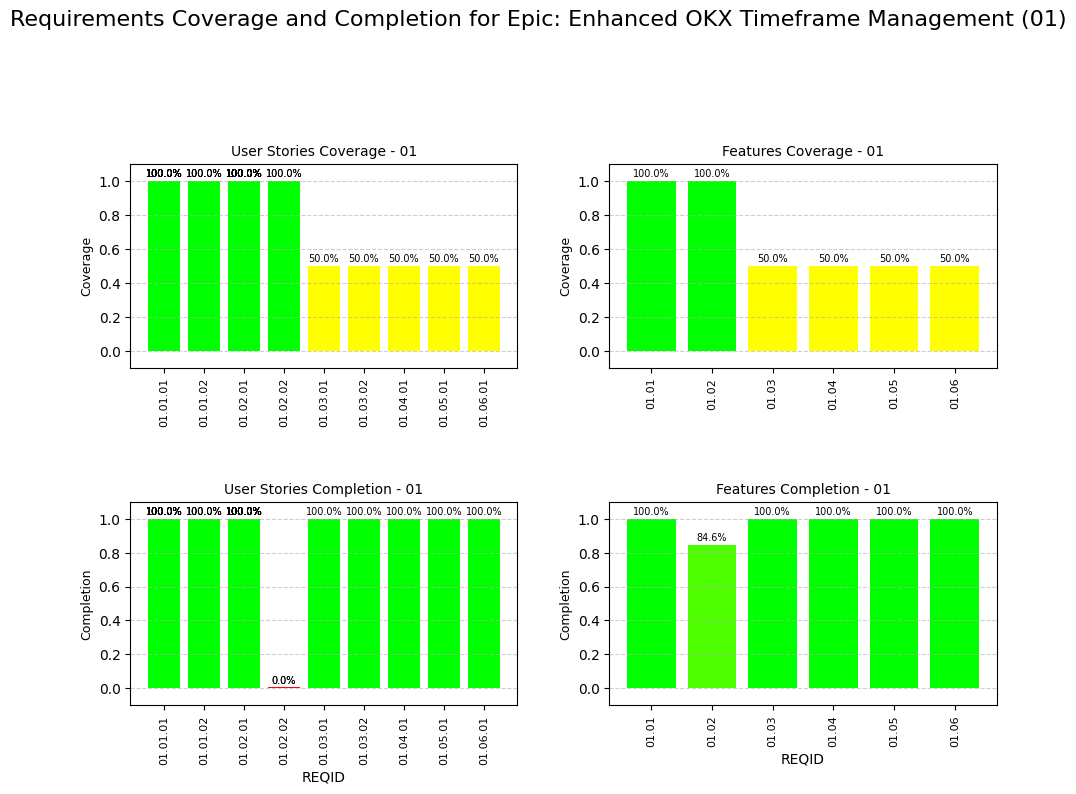


--- Plots for Epic: Data Integration and Persistence (02) ---


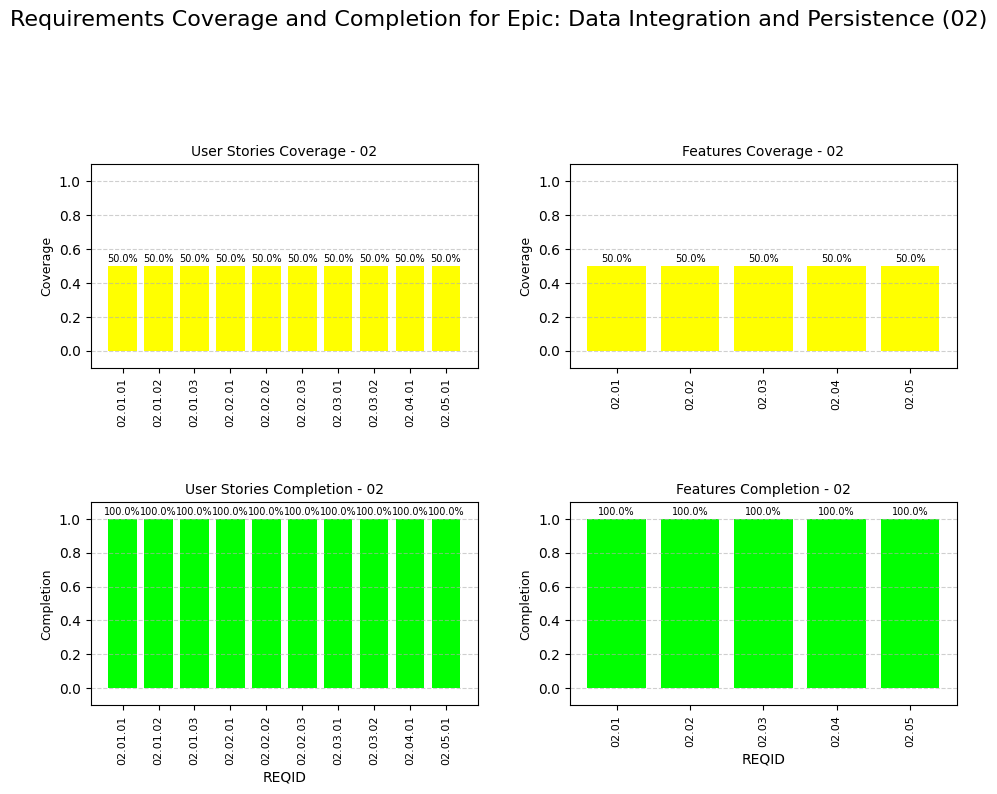


--- Plots for Epic: Market Whisperer Integration Layer (03) ---


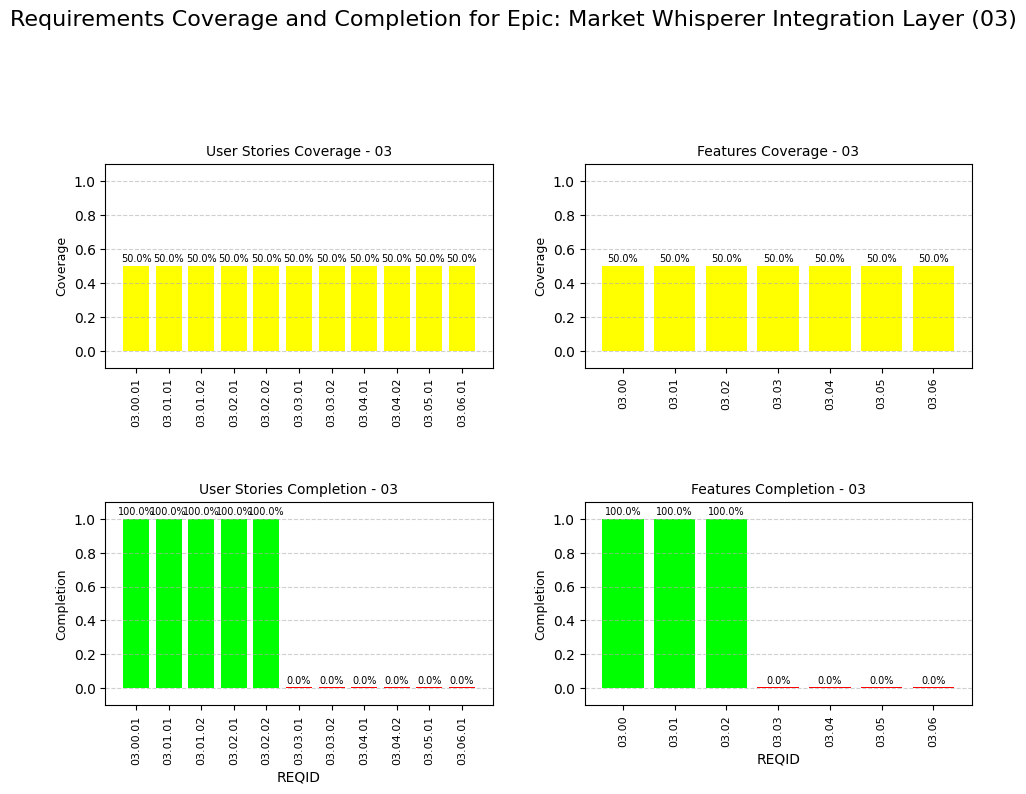


--- Plots for Epic: Frontend Components Adaptation (04) ---


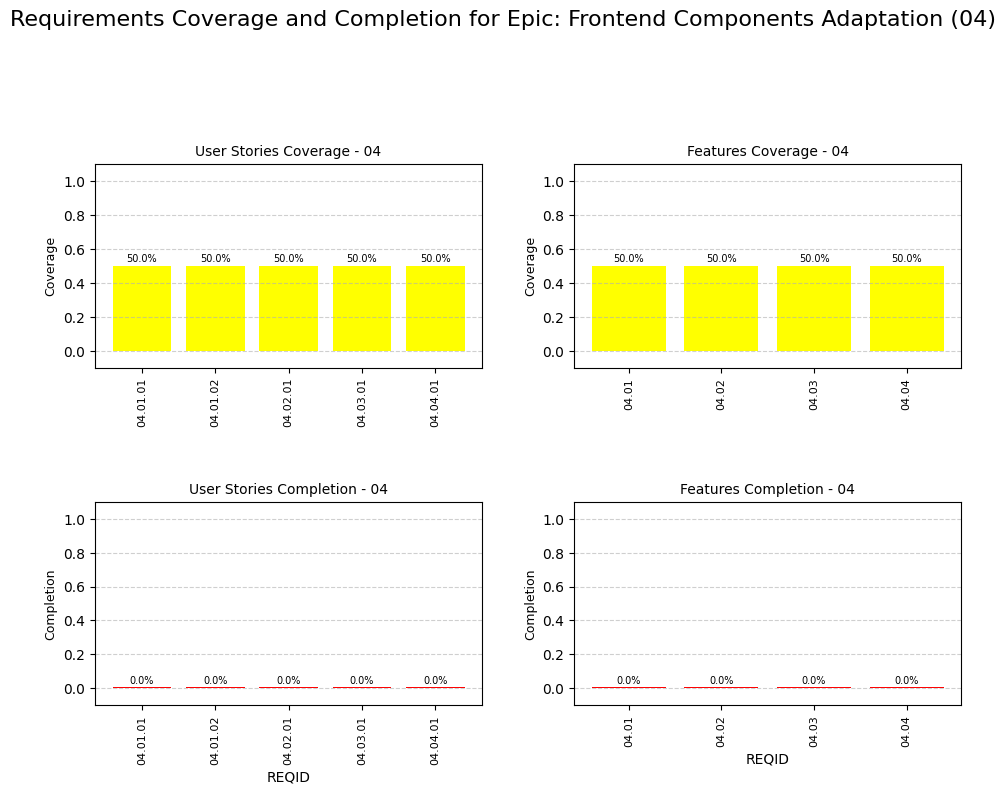


--- Plots for Epic: Configuration and Factory Updates (05) ---


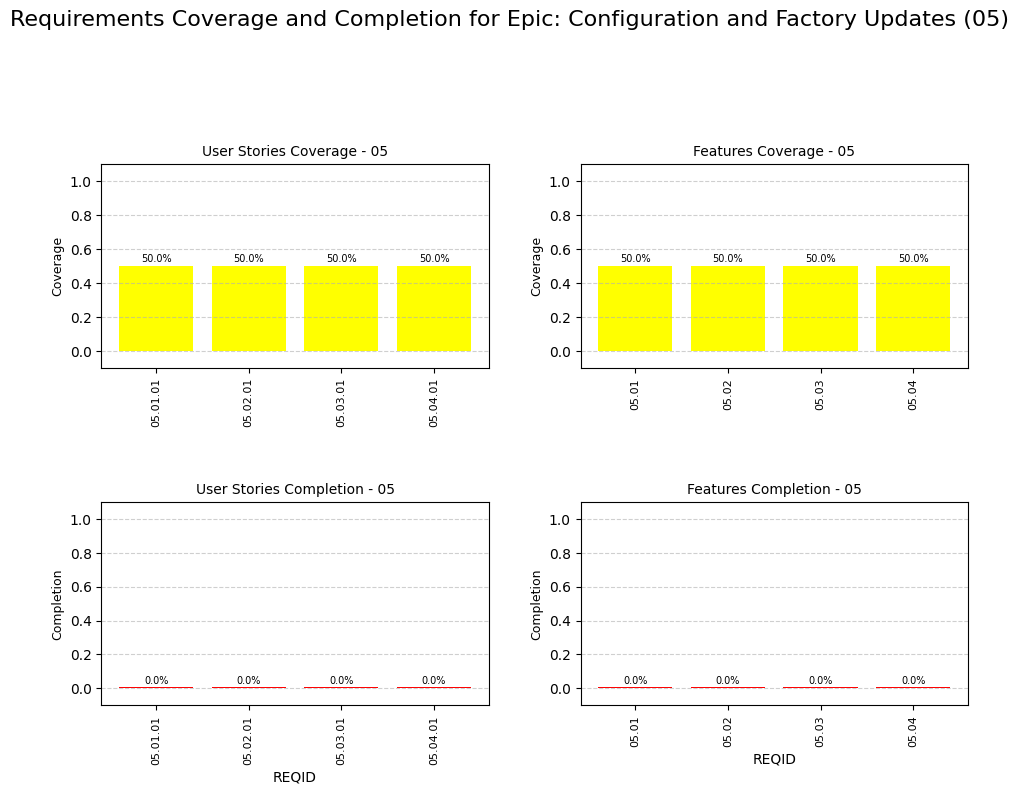


--- Plots for Epic: Testing and Validation (06) ---


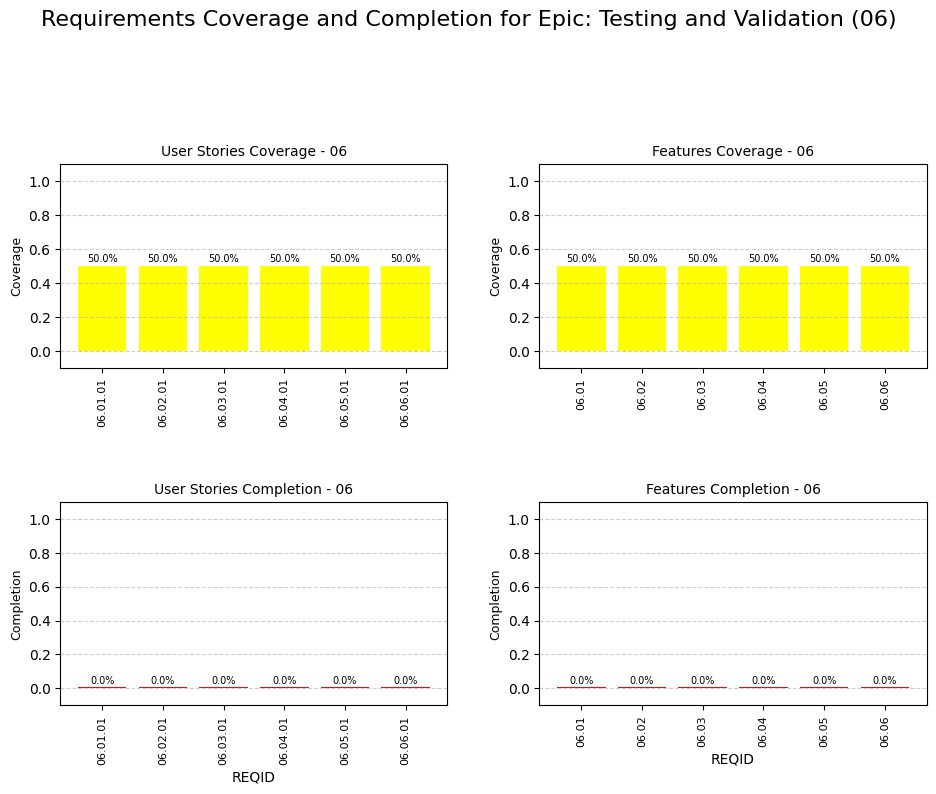


--- Plots for Epic: Deployment and Monitoring (07) ---


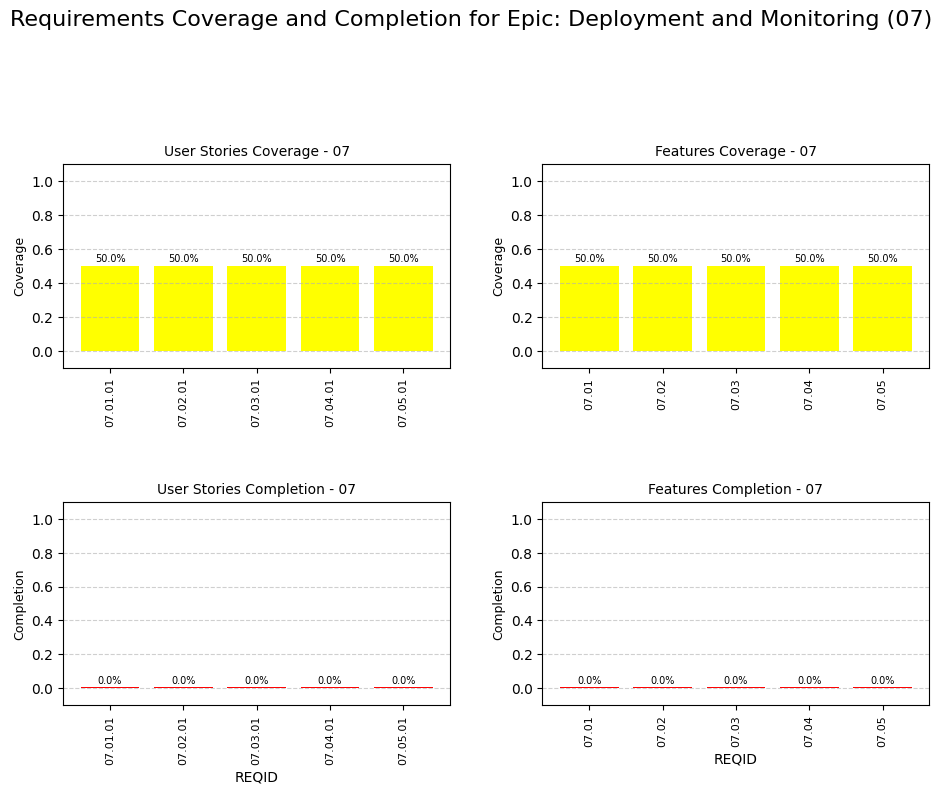


Finished generating all Epic-filtered graphs.


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Ensure matplotlib is set up for displaying plots
# plt.rcParams.update({'figure.autolayout': True}) # Uncomment if plots are cut off

print("\nGenerating Epic-filtered User Story and Feature graphs...")

# Loop through each Epic to generate filtered diagrams
for _, epic_row in epics.iterrows():
    epic_reqid = epic_row['REQID']
    epic_title = epic_row['REQTitle']

    # Filter user stories that belong to the current Epic
    # User Story REQIDs are in the format "XX.YY.ZZ" where XX is the Epic ID
    filtered_user_stories_for_epic = user_stories[
        user_stories['REQID'].str.startswith(epic_reqid + '.', na=False)
    ].copy()

    # Filter features that belong to the current Epic
    # Feature REQIDs are in the format "XX.YY" where XX is the Epic ID
    filtered_features_for_epic = features[
        features['REQID'].str.startswith(epic_reqid + '.', na=False)
    ].copy()

    print(f"\n--- Plots for Epic: {epic_title} ({epic_reqid}) ---")

    # Only create plots if there are relevant user stories or features for this Epic
    if not filtered_user_stories_for_epic.empty or not filtered_features_for_epic.empty:
        # Create a new figure and axes for each Epic's set of four graphs
        fig_epic, axs_epic = plt.subplots(2, 2, figsize=(10, 8)) # Adjusted figsize for potentially many bars
        fig_epic.suptitle(f"Requirements Coverage and Completion for Epic: {epic_title} ({epic_reqid})", fontsize=16, y=1.02)

        # Plot User Stories Coverage filtered by Epic
        plot_metric_bars(axs_epic[0, 0], filtered_user_stories_for_epic, 'Coverage', f'User Stories Coverage - {epic_reqid}')

        # Plot Features Coverage filtered by Epic
        plot_metric_bars(axs_epic[0, 1], filtered_features_for_epic, 'Coverage', f'Features Coverage - {epic_reqid}')

        # Plot User Stories Completion filtered by Epic
        plot_metric_bars(axs_epic[1, 0], filtered_user_stories_for_epic, 'Completion', f'User Stories Completion - {epic_reqid}')

        # Plot Features Completion filtered by Epic
        plot_metric_bars(axs_epic[1, 1], filtered_features_for_epic, 'Completion', f'Features Completion - {epic_reqid}')

        # Set overall X-axis label for the bottom row (Completion plots)
        for i in range(2):
            axs_epic[1, i].set_xlabel("REQID", fontsize=10)

        plt.tight_layout(rect=[0, 0, 1, 0.98], pad=3.0, h_pad=4.0) # Adjust rect for suptitle space
        plt.show()
    else:
        print(f"No relevant User Stories or Features found for Epic: {epic_title} ({epic_reqid}). Skipping plots for this Epic.")

print("\nFinished generating all Epic-filtered graphs.")


In [5]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns

# # Reload the combined CSV to ensure we have the latest data
# combined_df = pd.read_csv('use_cases_and_test_cases.csv', delimiter=';', dtype=str).fillna('')
# combined_df = combined_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# # Get unique Epics
# epics = combined_df[combined_df['REQType'] == 'Epic'].copy()

# print("Generating Epic-filtered graphs...")

# for _, epic_row in epics.iterrows():
#     epic_reqid = epic_row['REQID']
#     epic_title = epic_row['REQTitle']

#     # Filter data for the current Epic
#     # Epic ID is the first 2 characters of REQID
#     epic_data = combined_df[combined_df['REQID'].str.startswith(epic_reqid)].copy()

#     if epic_data.empty:
#         print(f"No data found for Epic: {epic_title} ({epic_reqid}). Skipping graphs.")
#         continue

#     # --- Graph 1: User Stories per Feature for the current Epic ---
#     features_in_epic = epic_data[epic_data['REQType'] == 'Feature'].copy()

#     # Get all User Stories under this Epic
#     user_stories_in_epic = epic_data[epic_data['REQType'] == 'UserStory'].copy()

#     if not user_stories_in_epic.empty:
#         # Extract Feature ID from User Story REQID
#         user_stories_in_epic['FeatureID'] = user_stories_in_epic['REQID'].str[:5]

#         # Count User Stories per Feature
#         us_counts_per_feature = user_stories_in_epic.groupby('FeatureID').size().reset_index(name='UserStoryCount')

#         # Map FeatureID back to Feature Title for better labels
#         feature_id_to_title = features_in_epic.set_index('REQID')['REQTitle'].to_dict()
#         us_counts_per_feature['FeatureTitle'] = us_counts_per_feature['FeatureID'].map(feature_id_to_title)
#         us_counts_per_feature['DisplayLabel'] = us_counts_per_feature.apply(
#             lambda x: f"{x['FeatureID']} - {x['FeatureTitle']}" if x['FeatureTitle'] else x['FeatureID'], axis=1
#         )

#         if not us_counts_per_feature.empty:
#             plt.figure(figsize=(12, 6))
#             sns.barplot(x='DisplayLabel', y='UserStoryCount', data=us_counts_per_feature, palette='viridis')
#             plt.title(f'User Stories per Feature for Epic: {epic_title} ({epic_reqid})')
#             plt.xlabel('Feature')
#             plt.ylabel('Number of User Stories')
#             plt.xticks(rotation=45, ha='right')
#             plt.tight_layout()
#             plt.show()
#         else:
#             print(f"No User Stories found for Features in Epic: {epic_title} ({epic_reqid}). Skipping User Story graph.")
#     else:
#         print(f"No User Stories found in Epic: {epic_title} ({epic_reqid}). Skipping User Story graph.")


#     # --- Graph 2: Test Cases per User Story for the current Epic ---
#     # Filter for actual test case assignments (where TCID is not empty)
#     tc_assignments_in_epic = epic_data[(epic_data['REQType'] == 'UserStory') & (epic_data['TCID'] != '')].copy()

#     if not tc_assignments_in_epic.empty:
#         # Count Test Cases per User Story REQID
#         tc_counts_per_us = tc_assignments_in_epic.groupby('REQID')['TCID'].nunique().reset_index(name='TestCaseCount')

#         # Map User Story REQID back to User Story Title for better labels
#         user_story_id_to_title = user_stories_in_epic.set_index('REQID')['REQTitle'].to_dict()
#         tc_counts_per_us['UserStoryTitle'] = tc_counts_per_us['REQID'].map(user_story_id_to_title)
#         tc_counts_per_us['DisplayLabel'] = tc_counts_per_us.apply(
#             lambda x: f"{x['REQID']} - {x['UserStoryTitle']}" if x['UserStoryTitle'] else x['REQID'], axis=1
#         )

#         if not tc_counts_per_us.empty:
#             plt.figure(figsize=(12, 6))
#             sns.barplot(x='DisplayLabel', y='TestCaseCount', data=tc_counts_per_us, palette='magma')
#             plt.title(f'Test Cases per User Story for Epic: {epic_title} ({epic_reqid})')
#             plt.xlabel('User Story')
#             plt.ylabel('Number of Test Cases')
#             plt.xticks(rotation=45, ha='right')
#             plt.tight_layout()
#             plt.show()
#         else:
#             print(f"No Test Cases found for User Stories in Epic: {epic_title} ({epic_reqid}). Skipping Test Case graph.")
#     else:
#         print(f"No Test Cases found for User Stories in Epic: {epic_title} ({epic_reqid}). Skipping Test Case graph.")

# print("\nFinished generating all Epic-filtered graphs.")

In [6]:
# import pandas as pd
# import datawrangler as dw

# df = pd.read_csv('use_cases_and_test_cases.csv', sep=';')
# dw.open_dataframe(df)

## old health ceck

In [7]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # --- Load and clean data ---
# uc = pd.read_csv('use_cases_and_test_cases.csv', sep=';')
# uc = uc.apply(lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x))

# # --- Identify types ---
# epics = uc[uc['REQType'] == 'Epic'].copy()
# features = uc[uc['REQType'] == 'Feature'].copy()
# user_stories = uc[uc['REQType'] == 'UserStory'].copy()
# test_cases = uc[uc['REQType'] == 'TestCase'].copy()

# # --- User Story <-> Test Case mapping (n:m) ---
# # Each row with a TCID in a UserStory row is a link
# us_tc_links = user_stories[['REQID', 'TCID']].dropna(subset=['TCID'])
# # Each test case may be linked to multiple user stories (n:m)
# tc_status = test_cases[['TCID', 'Status']].drop_duplicates()

# # --- User Story Coverage & Completion ---
# # Count test cases per user story (n:m)
# us_tc_counts = us_tc_links.groupby('REQID').size()
# user_stories['TC_count'] = user_stories['REQID'].map(us_tc_counts).fillna(0).astype(int)


# # Coverage: 0, 0.5, or 1.0
# def us_coverage(n):
#     if n == 0:
#         return 0.0
#     elif n == 1:
#         return 0.5
#     else:
#         return 1.0
# user_stories['Coverage'] = user_stories['TC_count'].apply(us_coverage)

# # Completion: % of test cases passed (user story)
# def us_completion(reqid):
#     linked_tcs = us_tc_links[us_tc_links['REQID'] == reqid]
#     if linked_tcs.empty:
#         return 0.0
#     # Merge with tc_status to get the actual status of linked test cases
#     merged_status = linked_tcs.merge(tc_status, on='TCID', how='left')
#     # Count passed test cases
#     passed_tcs = merged_status[merged_status['Status'].str.strip().str.lower() == 'pass'].shape[0]
#     total_tcs = merged_status.shape[0]
#     if total_tcs == 0:
#         return 0.0
#     return passed_tcs / total_tcs

# user_stories['Completion'] = user_stories['REQID'].apply(us_completion)


# # --- Feature Coverage & Completion (add columns to features DataFrame) ---
# # Modified to return a pandas Series with named columns
# def feature_coverage_and_completion(fid):
#     us_mask = user_stories['REQID'].str.startswith(fid + '.')
#     if us_mask.sum() > 0:
#         coverage = user_stories[us_mask]['Coverage'].mean()
#         completion = user_stories[us_mask]['Completion'].mean()
#     else:
#         coverage = 0.0
#         completion = 0.0
#     # Return a pandas Series explicitly, with column names
#     return pd.Series({'Coverage': coverage, 'Completion': completion})

# # No result_type='expand' is needed here, as the function returns a Series
# features[['Coverage', 'Completion']] = features['REQID'].apply(feature_coverage_and_completion)


# # --- Now build the KPI table as before ---
# kpi_rows = []

# # User Stories
# for _, row in user_stories.iterrows():
#     kpi_rows.append({
#         'REQID': row['REQID'],
#         'REQType': 'UserStory',
#         'REQTitle': row['REQTitle'],
#         'child_count': 0,
#         'TC_count': row['TC_count'],
#         'Coverage': row['Coverage'],
#         'Completion': row['Completion'],
#     })

# # Features
# for _, row in features.iterrows():
#     fid = row['REQID']
#     us_mask = user_stories['REQID'].str.startswith(fid + '.')
#     child_count = us_mask.sum()
#     tc_count = user_stories[us_mask]['TC_count'].sum()
#     if child_count > 0:
#         coverage = user_stories[us_mask]['Coverage'].mean()
#         completion = user_stories[us_mask]['Completion'].mean()
#     else:
#         coverage = 0.0
#         completion = 0.0
#     kpi_rows.append({
#         'REQID': fid,
#         'REQType': 'Feature',
#         'REQTitle': row['REQTitle'],
#         'child_count': child_count,
#         'TC_count': tc_count,
#         'Coverage': coverage,
#         'Completion': completion,
#     })

# # Epics
# for _, row in epics.iterrows():
#     eid = row['REQID']
#     feat_mask = features['REQID'].str.startswith(eid + '.')
#     child_count = feat_mask.sum()
#     tc_count = user_stories[user_stories['REQID'].str.startswith(eid + '.')]['TC_count'].sum()
#     if child_count > 0:
#         coverage = features[feat_mask]['Coverage'].mean()
#         completion = features[feat_mask]['Completion'].mean()
#     else:
#         coverage = 0.0
#         completion = 0.0
#     kpi_rows.append({
#         'REQID': eid,
#         'REQType': 'Epic',
#         'REQTitle': row['REQTitle'],
#         'child_count': child_count,
#         'TC_count': tc_count,
#         'Coverage': coverage,
#         'Completion': completion,
#     })

# kpi_df = pd.DataFrame(kpi_rows)

# # Define the 'percent' function (assuming it's defined elsewhere or needs to be added)
# def percent(value):
#     return f"{value:.1%}"

# kpi_df['Coverage'] = kpi_df['Coverage'].apply(percent)
# kpi_df['Completion'] = kpi_df['Completion'].apply(percent)
# kpi_df.to_csv('Completeness_KPI.csv', sep=';', index=False)
# display(kpi_df[['REQID', 'REQType', 'REQTitle', 'child_count', 'TC_count', 'Coverage', 'Completion']])
# # If you are in a Jupyter environment, uncomment the line below to display the table.
# # display(kpi_df[['REQID', 'REQType', 'REQTitle', 'child_count', 'TC_count', 'Coverage', 'Completion']])

## old kpis

In [8]:
# import matplotlib.pyplot as plt

# # --- User Story Coverage & Completion ---
# user_stories = uc[uc['REQType'] == 'UserStory'].copy()
# user_stories['TC_count'] = user_stories['REQID'].map(us_tc_counts).fillna(0).astype(int)
# # Coverage: 0, 0.5, or 1.0
# user_stories['Coverage'] = user_stories['TC_count'].apply(lambda n: min(n, 2) / 2)
# # Completion: fraction of assigned test cases with status 'passed'
# def us_completion(reqid):
#     tcs = tc[tc['REQID'] == reqid]
#     if len(tcs) == 0:
#         return 0.0
#     return (tcs['status'].str.lower() == 'passed').sum() / len(tcs)
# user_stories['Completion'] = user_stories['REQID'].apply(us_completion)

# # --- Feature Coverage & Completion ---
# features = uc[uc['REQType'] == 'Feature'].copy()
# features['US_count'] = features['REQID'].map(feature_us_counts).fillna(0).astype(int)
# def feature_user_stories(fid):
#     return user_stories[user_stories['REQID'].str.startswith(fid + '.')]
# def feature_coverage(fid):
#     stories = feature_user_stories(fid)
#     if len(stories) == 0:
#         return 0.0
#     return stories['Coverage'].mean()
# def feature_completion(fid):
#     stories = feature_user_stories(fid)
#     if len(stories) == 0:
#         return 0.0
#     return stories['Completion'].mean()
# features['Coverage'] = features['REQID'].apply(feature_coverage)
# features['Completion'] = features['REQID'].apply(feature_completion)

# # --- Epic Coverage & Completion ---
# epics = uc[uc['REQType'] == 'Epic'].copy()
# def epic_features(eid):
#     return features[features['REQID'].str.startswith(eid + '.')]
# def epic_coverage(eid):
#     feats = epic_features(eid)
#     if len(feats) == 0:
#         return 0.0
#     return feats['Coverage'].mean()
# def epic_completion(eid):
#     feats = epic_features(eid)
#     if len(feats) == 0:
#         return 0.0
#     return feats['Completion'].mean()
# epics['Coverage'] = epics['REQID'].apply(epic_coverage)
# epics['Completion'] = epics['REQID'].apply(epic_completion)

# # --- Show tables with percentages ---
# def percent(x):
#     return f"{100*x:.0f}%"

# print("User Story Coverage & Completion Table:")
# display(user_stories[['REQID', 'REQTitle', 'TC_count', 'Coverage', 'Completion']].assign(
#     Coverage=lambda df: df['Coverage'].apply(percent),
#     Completion=lambda df: df['Completion'].apply(percent)
# ))

# print("\nFeature Coverage & Completion Table:")
# display(features[['REQID', 'REQTitle', 'US_count', 'Coverage', 'Completion']].assign(
#     Coverage=lambda df: df['Coverage'].apply(percent),
#     Completion=lambda df: df['Completion'].apply(percent)
# ))

# print("\nEpic Coverage & Completion Table:")
# display(epics[['REQID', 'REQTitle', 'Coverage', 'Completion']].assign(
#     Coverage=lambda df: df['Coverage'].apply(percent),
#     Completion=lambda df: df['Completion'].apply(percent)
# ))

# # --- Print overall percentages ---
# overall_us_coverage = user_stories['Coverage'].mean()
# overall_us_completion = user_stories['Completion'].mean()
# overall_feature_coverage = features['Coverage'].mean()
# overall_feature_completion = features['Completion'].mean()
# overall_epic_coverage = epics['Coverage'].mean()
# overall_epic_completion = epics['Completion'].mean()

# print(f"\nOverall User Story Coverage: {percent(overall_us_coverage)}")
# print(f"Overall User Story Completion: {percent(overall_us_completion)}")
# print(f"Overall Feature Coverage: {percent(overall_feature_coverage)}")
# print(f"Overall Feature Completion: {percent(overall_feature_completion)}")
# print(f"Overall Epic Coverage: {percent(overall_epic_coverage)}")
# print(f"Overall Epic Completion: {percent(overall_epic_completion)}")

# # --- Bar charts ---
# plt.figure(figsize=(15, 4))
# plt.subplot(1, 3, 1)
# user_stories['Coverage'].value_counts().sort_index().plot(kind='bar', title='User Stories Coverage')
# plt.subplot(1, 3, 2)
# features['Coverage'].value_counts().sort_index().plot(kind='bar', title='Features Coverage')
# plt.subplot(1, 3, 3)
# epics['Coverage'].value_counts().sort_index().plot(kind='bar', title='Epics Coverage')
# plt.tight_layout()
# plt.show()